## lenet architecture with adam optimizer weight decay

In [ ]:
import tensorflow as tf
from tensorflow import keras as k
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tf_data_augmentation import data_augment

In [ ]:
tf.keras.utils.set_random_seed(42) # sets the Python, NumPy and TensorFlow seed
# tf.config.experimental.enable_op_determinism() # forces threads to work in deterministic way

## Data load and splitting

In [ ]:
(train_ds, val_ds), info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True, as_supervised=True, split=['train+test[:70%]', 'test[70%:]'])

# Calculate the number of classes i.e.37
NUM_CLASSES = info.features['label'].num_classes
num_train = len(train_ds)
num_val = len(val_ds)
# num_test = len(test_ds)

print(f"Number of classes: {NUM_CLASSES}")
print(f"Number of training samples: {num_train}")
print(f"Number of validation samples: {num_val}")
# print(f"Number of test samples: {num_test}")

Number of classes: 37
Number of training samples: 6248
Number of validation samples: 1101


## hypermaters

In [ ]:
import os
BATCH_SIZE = 256
IMAGE_SIZE = 128
# Set environment variables
os.environ['NUM_CLASSES'] = str(NUM_CLASSES)
os.environ['BATCH_SIZE'] = str(BATCH_SIZE)
os.environ['IMAGE_SIZE'] = str(IMAGE_SIZE)

## visualization

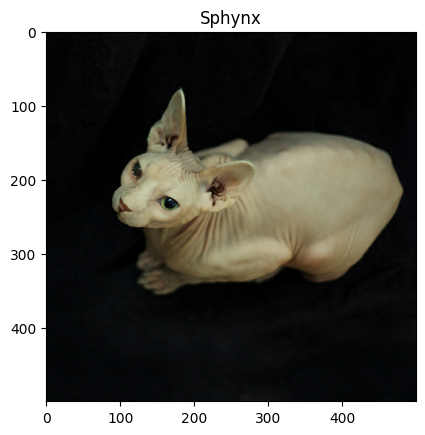

In [ ]:
get_label_name = info.features['label'].int2str
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title( get_label_name( label ) )

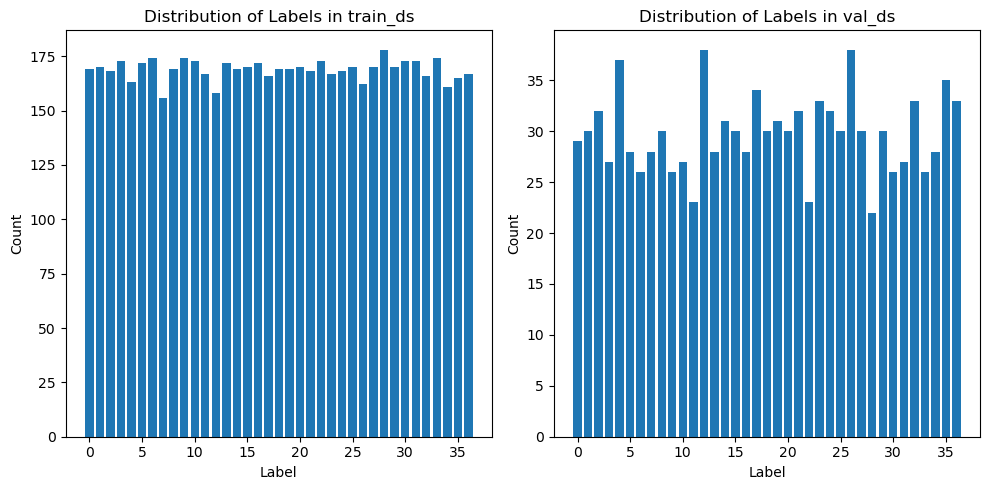

In [ ]:
import numpy as np

# Get the labels from train_ds and val_ds
train_labels = np.array([label.numpy() for _, label in train_ds])
val_labels = np.array([label.numpy() for _, label in val_ds])

# Count the occurrences of each label in train_ds and val_ds
train_label_counts = np.bincount(train_labels)
val_label_counts = np.bincount(val_labels)

# Plot the histograms
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(range(len(train_label_counts)), train_label_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in train_ds')

plt.subplot(1, 2, 2)
plt.bar(range(len(val_label_counts)), val_label_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in val_ds')

plt.tight_layout()
plt.show()

## Data Augmentation

In [ ]:
train_ds, val_ds = data_augment(train_ds, val_ds)

In [ ]:
def lenet5(input_shape, num_classes: int = 10):
    k.utils.set_random_seed(42)
    model = k.Sequential([
        k.layers.Input(shape=input_shape),
        k.layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), padding='valid', activation='relu',
                        kernel_initializer=k.initializers.GlorotUniform(), bias_initializer='zeros'),
        k.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        k.layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), padding='valid', activation='relu',
                        kernel_initializer=k.initializers.GlorotUniform(), bias_initializer='zeros'),
        k.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        k.layers.Flatten(),
        k.layers.Dense(units=120, activation='relu', kernel_initializer=k.initializers.HeUniform(), bias_initializer='zeros'),
        k.layers.Dense(units=84, activation='relu', kernel_initializer=k.initializers.HeUniform(), bias_initializer='zeros'),
        k.layers.Dense(units=num_classes, activation='softmax', kernel_initializer=k.initializers.GlorotUniform(), bias_initializer='zeros')
    ])
    return model

In [ ]:
lenet_model = lenet5((IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=NUM_CLASSES)
lenet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 124, 124, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 62, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 58, 58, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 29, 29, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 13456)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │       1,614,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 37)                  │           3,145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,631,021 (6.22 MB)

 Trainable params: 1,631,021 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lenet_model.compile(
        optimizer=k.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.07),
        loss=k.losses.CategoricalCrossentropy(from_logits=False, reduction='sum_over_batch_size'),
        metrics=[k.metrics.CategoricalAccuracy()],
    )
hist = lenet_model.fit(train_ds, epochs=6, shuffle=False, validation_data=val_ds, verbose=1, callbacks=[k.callbacks.EarlyStopping(patience=5)])

Epoch 1/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 125s 343ms/step - categorical_accuracy: 0.0480 - loss: 3.5712 - val_categorical_accuracy: 0.0654 - val_loss: 3.4135
Epoch 2/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - categorical_accuracy: 0.0908 - loss: 3.3655 - val_categorical_accuracy: 0.1253 - val_loss: 3.2446
Epoch 3/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - categorical_accuracy: 0.1299 - loss: 3.2084 - val_categorical_accuracy: 0.1490 - val_loss: 3.1466
Epoch 4/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - categorical_accuracy: 0.1593 - loss: 3.0955 - val_categorical_accuracy: 0.1589 - val_loss: 3.0701
Epoch 5/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - categorical_accuracy: 0.1765 - loss: 3.0198 - val_categorical_accuracy: 0.1689 - val_loss: 3.0243
Epoch 6/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - categorical_accuracy: 0.1881 - loss: 2.9566 - val_categorical_accuracy: 0.1744 - val_loss: 3.0417


In [ ]:
lenet_model.compile(
        optimizer=k.optimizers.AdamW(learning_rate=0.00001, weight_decay=0.07),
        loss=k.losses.CategoricalCrossentropy(from_logits=False, reduction='sum_over_batch_size'),
        metrics=[k.metrics.CategoricalAccuracy()],
    )
hist = lenet_model.fit(train_ds, epochs=6, shuffle=False, validation_data=val_ds, verbose=1, callbacks=[k.callbacks.EarlyStopping(patience=5)])

Epoch 1/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - categorical_accuracy: 0.2194 - loss: 2.8694 - val_categorical_accuracy: 0.1944 - val_loss: 2.9790
Epoch 2/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - categorical_accuracy: 0.2190 - loss: 2.8674 - val_categorical_accuracy: 0.1971 - val_loss: 2.9681
Epoch 3/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - categorical_accuracy: 0.2184 - loss: 2.8535 - val_categorical_accuracy: 0.1989 - val_loss: 2.9638
Epoch 4/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - categorical_accuracy: 0.2258 - loss: 2.8372 - val_categorical_accuracy: 0.2016 - val_loss: 2.9612
Epoch 5/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - categorical_accuracy: 0.2244 - loss: 2.8358 - val_categorical_accuracy: 0.1989 - val_loss: 2.9625
Epoch 6/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - categorical_accuracy: 0.2273 - loss: 2.8268 - val_categorical_accuracy: 0.2025 - val_loss: 2.9601


In [ ]:
lenet_model.compile(
        optimizer=k.optimizers.AdamW(learning_rate=0.000001, weight_decay=0.07),
        loss=k.losses.CategoricalCrossentropy(from_logits=False, reduction='sum_over_batch_size'),
        metrics=[k.metrics.CategoricalAccuracy()],
    )
hist = lenet_model.fit(train_ds, epochs=6, shuffle=False, validation_data=val_ds, verbose=1, callbacks=[k.callbacks.EarlyStopping(patience=5)])

Epoch 1/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 64s 369ms/step - categorical_accuracy: 0.2265 - loss: 2.8233 - val_categorical_accuracy: 0.2025 - val_loss: 2.9572
Epoch 2/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - categorical_accuracy: 0.2330 - loss: 2.8091 - val_categorical_accuracy: 0.2025 - val_loss: 2.9583
Epoch 3/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - categorical_accuracy: 0.2326 - loss: 2.8221 - val_categorical_accuracy: 0.2025 - val_loss: 2.9589
Epoch 4/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - categorical_accuracy: 0.2335 - loss: 2.8099 - val_categorical_accuracy: 0.2035 - val_loss: 2.9585
Epoch 5/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - categorical_accuracy: 0.2321 - loss: 2.8112 - val_categorical_accuracy: 0.2025 - val_loss: 2.9568
Epoch 6/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - categorical_accuracy: 0.2327 - loss: 2.8119 - val_categorical_accuracy: 0.2025 - val_loss: 2.9582
